# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    res = []
    for rel,pred in zip(relevant, predicted):
      if len(pred)>k:
          pred = pred[:k]
      score = 0.0
      num_hits = 0.0
      for i,p in enumerate(pred):
          if p in rel and p not in pred[:i]:
              num_hits += 1.0
              score += num_hits / (i+1.0)
      if not rel:
          res.append(0.0)
      res.append(score / min(len(rel), k))

    return sum(res)/len(res)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for user in tqdm(np.unique(self.ratings['userId'])):
          test_preds.append(self.recommend(user))
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    res = (np.sum(np.logical_and(ratings,user_vector).astype(int), 1))/(((np.sum(ratings, 1))**(1/2))*((np.sum(user_vector))**(1/2)))
    res[np.isnan(res)] = 0
    return res

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    return np.abs(np.sum(np.logical_and(ratings,user_vector).astype(int), 1))/np.abs(np.sum(np.logical_or(ratings,user_vector).astype(int), 1))

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [16]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        sim = np.array(self.similarity(self.R[uid]))
        sim[np.logical_or(sim <= self.alpha, np.round(sim, 10) >= 1)] = 0
        if np.sum(np.abs(sim)) == 0.0:
          track_rs = np.sum(self.R*sim.reshape(-1,1), 0)
        else:
          track_rs = np.sum(self.R*sim.reshape(-1,1), 0)/np.sum(np.abs(sim))
        return np.argsort(track_rs)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [17]:
import random

def get_random_recommendations(user_count, tracks_count, k):
  return np.random.randint(0, tracks_count, size=(user_count, k)) 

In [18]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
jac = User2User(train_ratings, jaccard)
pear = User2User(train_ratings, pearson)

In [19]:
jac_rec = jac.get_test_recommendations(50)

  0%|          | 0/241 [00:00<?, ?it/s]

In [20]:
pear_rec = pear.get_test_recommendations(50)

  0%|          | 0/241 [00:00<?, ?it/s]

In [21]:
rand_rec = get_random_recommendations(len(np.unique(ratings['userId'])), len(np.unique(ratings['trackId'])), 50)

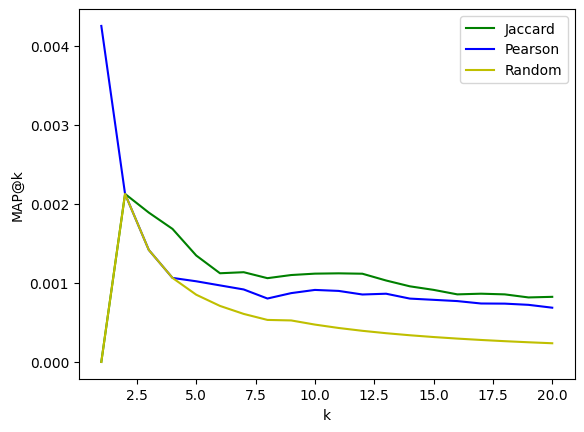

In [22]:
jac_mapk = []
pear_mapk = []
rand_mapk = []
k = np.arange(1,21)
for i in k:
  jac_mapk.append(mapk(test_relevant, jac_rec, k=i))
  pear_mapk.append(mapk(test_relevant, pear_rec, k=i))
  rand_mapk.append(mapk(test_relevant, rand_rec, k=i))
plt.plot(k,jac_mapk,'g',k,pear_mapk,'b',k,rand_mapk,'y')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend(['Jaccard','Pearson','Random'])
plt.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [23]:
from scipy.sparse import csr_array as csr

In [24]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
def pearson_csr(ratings: csr, user_vector: csr) -> csr:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    return (csr.sum(ratings*user_vector, 1))/((csr.sum(ratings, 1))**(1/2))*((csr.sum(user_vector))**(1/2))

def jaccard_csr(ratings: csr, user_vector: csr) -> csr:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    return np.abs(csr.sum(ratings*user_vector, 1))/np.abs(csr.sum(ratings, 1)+csr.sum(user_vector)-csr.sum(ratings*user_vector, 1))

In [25]:
class User2User_csr(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: csr):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(csr(self.R), user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        sim = csr(self.similarity(csr(self.R[uid])))
        sim[sim <= self.alpha] = 0
        sim[np.round(sim, 10) >= 1] = 0
        if csr.sum(np.abs(sim)) == 0.0:
          track_rs = csr.sum(csr(self.R)*sim.reshape(-1,1), 0)
        else:
          track_rs = csr.sum(csr(self.R)*sim.reshape(-1,1), 0)/csr.sum(np.abs(sim))
        return np.argsort(track_rs)[::-1]

In [26]:
jac_csr = User2User(train_ratings, jaccard)
pear_csr = User2User(train_ratings, pearson)

In [27]:
jac_rec_csr = jac.get_test_recommendations(50)

  0%|          | 0/241 [00:00<?, ?it/s]

In [28]:
pear_rec_csr = pear.get_test_recommendations(50)

  0%|          | 0/241 [00:00<?, ?it/s]

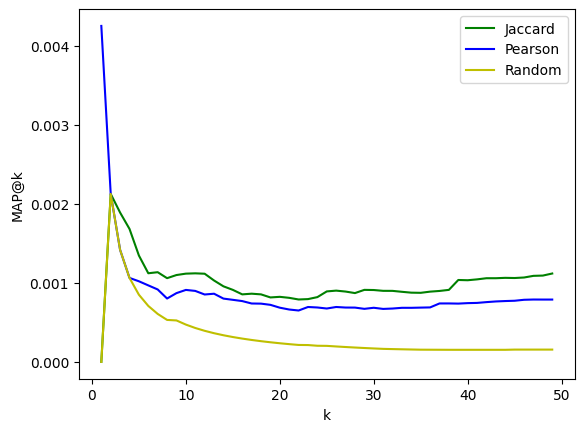

In [29]:
jac_mapk_csr = []
pear_mapk_csr = []
rand_mapk_csr = []
k = np.arange(1,50)
for i in k:
  jac_mapk_csr.append(mapk(test_relevant, jac_rec_csr, k=i))
  pear_mapk_csr.append(mapk(test_relevant, pear_rec_csr, k=i))
  rand_mapk_csr.append(mapk(test_relevant, rand_rec, k=i))
plt.plot(k,jac_mapk_csr,'g',k,pear_mapk_csr,'b',k,rand_mapk_csr,'y')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend(['Jaccard','Pearson','Random'])
plt.show()

*Я смотрела время по tqdm. Не сказать, что время работы сильно ускорилось, возможно, при каких-то прогонах стало побыстрее. Сам график стал выглядеть более хаотичным, но все равно похож на прошлый график*

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [30]:
model = pear_csr
user_id = np.random.randint(0, model.n_users)

In [31]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
257,The Lady In Red,['Chris De Burgh']
630,Every Breath You Take,['The Police']
760,Wonderful Life,['Black']
805,Zombie,['The Cranberries']
886,In The Army Now,['Status Quo']
1019,It's My Life,['Bon Jovi']
1073,Smells Like Teen Spirit,['Nirvana']
1081,Come As You Are,['Nirvana']
1137,Nothing Else Matters,['Metallica']
1302,I Just Called To Say I Love You,['Stevie Wonder']


In [32]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

  0%|          | 0/241 [00:00<?, ?it/s]

Predicted tracks:


,name,artists
49704,Девочка-война,['HammAli & Navai']
50764,Без тебя я не я,"['HammAli & Navai', 'JONY']"
27516,Ты словно целая вселенная,['Jah Khalib']
2814,Numb,['Linkin Park']
45482,На восьмом этаже,['Джиган']
52075,Kукушка,['Полина Гагарина']
4744,Hero,['Skillet']
41935,Запах моей женщины,"['Адлер Коцба', 'Timran']"
35064,Thunder,['Imagine Dragons']
48850,До встречи на танцполе,['GAYAZOV$ BROTHER$']


In [33]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
34826,Зачем я тебе?!,['Artik & Asti']
34885,Amsterdam,['Nothing But Thieves']
34890,Hard Times,['Paramore']
34937,Friday Night‬‬‬,['Vigiland']
35150,#ТАМАДА,"['Miyagi & Эндшпиль', 'Al I Bo', 'Wooshendoo']"
35524,In Cold Blood,['alt-J']
35931,Creature Comfort,['Arcade Fire']
37147,Disco Tits,['Tove Lo']
38808,The Beautiful & Damned,"['G-Eazy', 'Zoe Nash']"
39104,Him & I,"['G-Eazy', 'Halsey']"


*По общему впечатлению кажется, что предсказания подходят. Так как юзер выбирается рандомно, сложно конкретно сравнить жанры и языки песен, но по тому, что я видела, кажется, что предсказания действительно подходящие*

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

*В этой части опиралась на источник: https://medium.com/m/global-identity-2?redirectUrl=https%3A%2F%2Fblog.insightdatascience.com%2Fexplicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea*

**LFM:**
$$
\hat{r}_{ui} = \langle p_u, q_i \rangle = p_u^T*q_i
$$
\
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right) = \sum_{(u, i) \in R} (r_{ui} - r 
̄ _u-r ̄ _i-p_u^T*q_i)^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$
\
$$
\frac{σL}{σr 
̄ _u} = 2(r_{ui} - r 
̄ _u-r ̄ _i-p_u^T*q_i)(-1) + 2\lambda r 
̄ _u
$$
\
$$
\frac{σL}{σr 
̄ _u} = 2(error_{ui})(-1) + 2\lambda r 
̄ _u
$$
\
$$
\frac{σL}{σr 
̄ _u} = -error_{ui} + \lambda r 
̄ _u
$$
\
$$
p_u ← p_u + \eta(error_{ui}q_i - \lambda p_u)
$$
\
$$
q_i ← q_i + \eta(error_{ui}p_u - \lambda q_i)
$$
\
**ALS:**

$$
\hat{r}_{ui} = \langle p_u, q_i \rangle = p_u^T*q_i
$$
\
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right) = \sum_{(u, i) \in R} (r_{ui} - p_u^T*q_i)^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$
\
$$
\frac{σL}{σp_u} = -2\sum_{i} (p_u^T*q_i - r_{ui})q_i^T + 2\lambda p_u^T
$$
\
$$
0 = -(r_u - p_u^TQ^T)Q + \lambda p_u^T
$$
\
$$
p_u^T(Q^TQ + \lambda I) = r_uQ
$$
\
$$
p_u^T=r_uQ(Q^TQ+\lambda I)^{-1}
$$
\
*Для Q вывод аналогичен предыдущему:*
$$
q_i^T=r_iP(P^TP+\lambda I)^{-1}
$$



**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [34]:
from numpy.linalg import solve

class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.R[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.lr * (e - self.lamb * self.user_bias[u])
            self.item_bias[i] += self.lr * (e - self.lamb * self.item_bias[i])
            
            #Update latent factors
            self.P[u, :] += self.lr * (e * self.Q[i, :] - self.lamb * self.P[u,:])
            self.Q[i, :] += self.lr * (e * self.P[u, :] - self.lamb * self.Q[i,:])
                                    
    def als(self, latent_vectors, fixed_vecs, ratings, type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * self.lamb

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))

        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * self.lamb
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))

        return latent_vectors

    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.mode == 'als':
            return self.P[u, :].dot(self.Q[i, :].T)
        elif self.mode == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.P[u, :].dot(self.Q[i, :].T)
            return prediction

    def fit(self, num_iters=5):
        if self.mode == 'sgd':
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.R[np.where(self.R != 0)])
            self.sample_row, self.sample_col = self.R.nonzero()
            self.n_samples = len(self.sample_row)

        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                self.P = self.als(self.P, self.Q, self.R, type='user')
                self.Q = self.als(self.Q, self.P, self.R, type='item')

    def recommend(self, uid):
        if self.mode == 'sgd':
          pred_rating = self.global_bias + self.user_bias[uid] + self.item_bias
          pred_rating += self.P[uid] @ self.Q.T
          return np.argsort(pred_rating)[::-1]
        
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [35]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

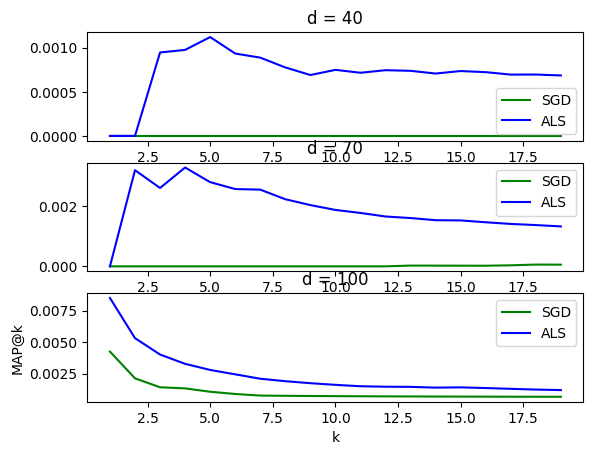

In [36]:
D = [40, 70, 100]
K = np.arange(1, 20)
fig, ax = plt.subplots(3, 1)
for i in range(len(D)):
  hid_sgd = HiddenVars(train_ratings, dim=D[i], mode='sgd')
  hid_als = HiddenVars(train_ratings, dim=D[i], mode='als')
  hid_sgd.fit()
  rec_sgd = hid_sgd.get_test_recommendations(50)
  hid_als.fit()
  rec_als = hid_als.get_test_recommendations(50)
  mapk_sgd = []
  mapk_als = []
  for k in K:
    mapk_sgd.append(mapk(test_relevant, rec_sgd, k=k))
    mapk_als.append(mapk(test_relevant, rec_als, k=k))
  ax[i].plot(K,mapk_sgd,'g',K,mapk_als,'b')
  ax[i].title.set_text('d = '+str(D[i]))
  plt.xlabel('k')
  plt.ylabel('MAP@k')
  ax[i].legend(['SGD','ALS'])
plt.show()

*По графику качество выглядит получше, чем для предыдущих моделей. И скорость намного выше. Я не подбирала количество эпох, потому что этого не было в задании, возможно, это бы еще повысило качество*

In [40]:
model = HiddenVars(train_ratings, dim=40, mode='als')

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [41]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [42]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
36346,Call on Me,['Starley'],0.595894
30121,Порно,['Кровосток'],0.583048
57911,For You,['Dani Corbalan'],0.580583
57527,Электрический ток,['Увула'],0.572668
23053,Mean Blues,['Floyd Lee Band'],0.563355
56799,Танцпол,['Greench'],0.561631
58559,Трава у дома,['Земляне'],0.553186
51603,The Trooper and the Maid,['Rising Gael'],0.549427
39666,Mean It,['K.Flay'],0.549045


**Продлеваю дедлайн по справке о болезни, я ее прикрепила к дз в энитаске**